In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astropy import units

import hera_sim
from hera_sim import Simulator
from hera_sim.visibilities import HealVis, VisCPU
import pyuvsim
import uvtools

In [2]:
pyuvsim.analytic_diffuse.models.sky_models

['monopole',
 'cosza',
 'polydome',
 'projgauss',
 'gauss_zenith',
 'gauss',
 'xysincs']

In [3]:
cfg_path = Path("end_to_end")
csv_path = cfg_path / "array_layout.csv"
obsparam_file = cfg_path / "obsparams.yaml"

In [4]:
# # Code for making the array_layout.csv file
# import csv
# fields = ["Name", "Number", "BeamID", "E", "N", "U"]
# antpos = hera_sim.antpos.hex_array(2, split_core=False, outriggers=0)
# ant_to_beam = np.zeros(len(antpos), dtype=int)
# rows = list(
#     [f"ANT{ant}", ant, ant_to_beam[ant], e, n, u]
#     for ant, (e, n, u) in antpos.items()
# )
# with open(csv_path, "w") as f:
#     writer = csv.writer(f, delimiter=' ')
#     writer.writerow(fields)
#     writer.writerow([])
#     writer.writerows(rows)

In [5]:
uvd, beam_list, beam_ids = pyuvsim.initialize_uvdata_from_params(str(obsparam_file))
uvd = pyuvsim.simsetup._complete_uvdata(uvd)
beam_ids = {int(name[-1]): beam_id for name, beam_id in beam_ids.items()}
beam_list.set_obj_mode()

In [6]:
sky_model, params = pyuvsim.create_mock_catalog(
    time=np.mean(np.unique(uvd.time_array)),
    arrangement="random",
    Nsrcs=200,
)

In [7]:
# # Make a diffuse model... Once I figure out how
# diffuse_model, params = pyuvsim.create_mock_catalog(
#     time=np.mean(np.unique(uvd.time_array)),
#     arrangement="diffuse",
#     diffuse_model="projgauss",
#     diffuse_params={"a": 0.5},
# )

In [8]:
sky_model_recarray = sky_model.to_recarray()

In [9]:
ras = np.array(list(row[1] for row in sky_model_recarray))
decs = np.array(list(row[2] for row in sky_model_recarray))
src_pos = np.array([ras, decs]).T * units.deg.to("rad")
ref_fluxes = np.random.lognormal(mean=1, sigma=5, size=len(ras))
ref_fluxes[ref_fluxes > 20] = 1 / ref_fluxes[ref_fluxes > 20]
indices = np.random.uniform(low=-3, high=-1, size=len(ras))

In [10]:
freqs = np.unique(uvd.freq_array)
ref_freq = np.mean(freqs)
scales = np.exp(np.outer(np.log(freqs / ref_freq), indices))
fluxes = ref_fluxes.reshape(1,-1) * scales

In [11]:
vis_cpu_sim = VisCPU(
    uvdata=uvd.copy(),
    beams=beam_list,
    beam_ids=list(beam_ids.keys()),
    point_source_pos=src_pos,
    point_source_flux=fluxes,
#    use_pixel_beams=False,
)

In [12]:
vis_cpu_sim.simulate();

invalid value encountered in sqrt


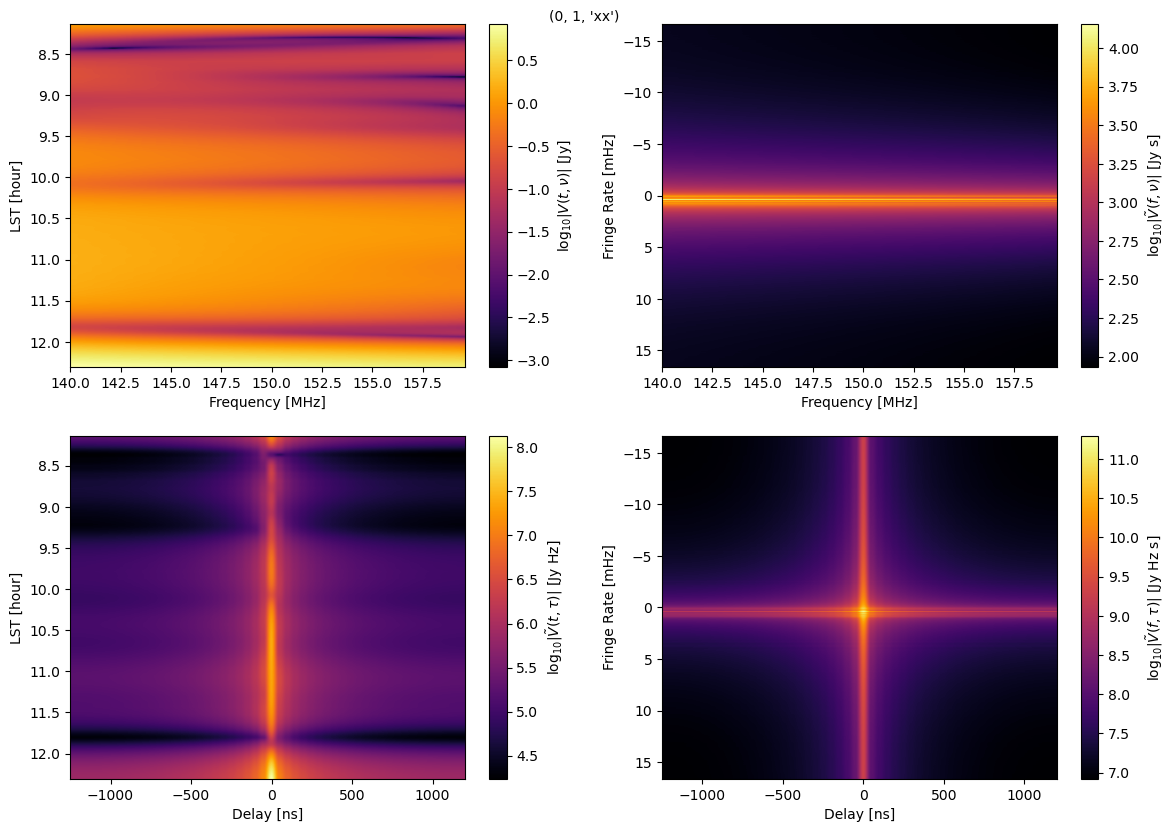

In [13]:
fig = uvtools.plot.fourier_transform_waterfalls(vis_cpu_sim.uvdata, antpairpol=(0,1,'xx'))

In [14]:
sim = Simulator(data=vis_cpu_sim.uvdata.copy())

In [15]:
# # Figure out how to get the beam integral for calculating noise
# beam = beam_list[0]

In [16]:
hera_sim.defaults.set("h1c")

In [17]:
systematics = {
#    "thermal_noise": {"Trx": 100, "omega_p": omega_p, "seed": "initial"},
    "gains": {"seed": "once"},
    "reflections": {"amp": 1e-2, "dly": 250, "amp_jitter": 5e-2, "dly_jitter": 5, "seed": "once"},
    "cross_coupling_spectrum": {"dly_range": (800,1000), "amp_jitter": 1e-2, "dly_jitter": 20, "seed": "once"},
}

In [18]:
sim.run_sim(**systematics)

You are adding visibilities to a data array *after* multiplicative effects have been introduced.


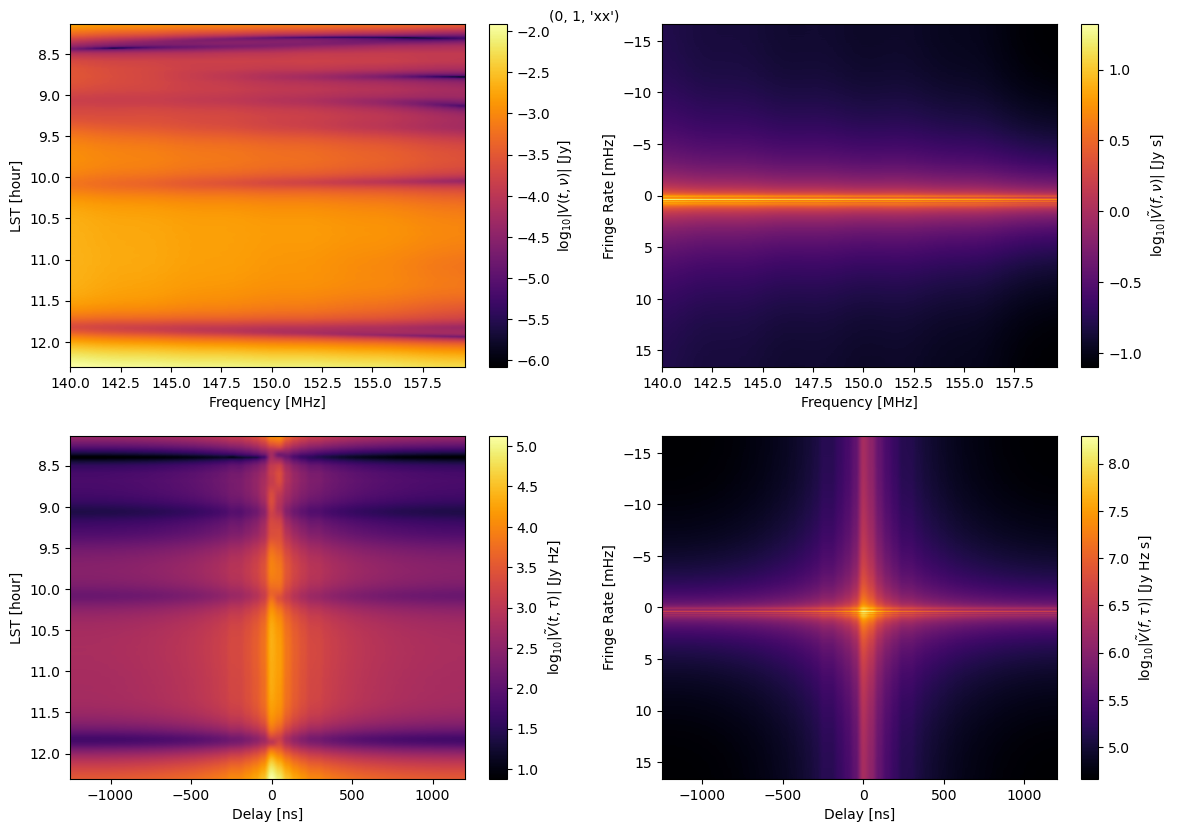

In [19]:
fig = uvtools.plot.fourier_transform_waterfalls(sim.data, antpairpol=(0,1,'xx'))